In [61]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import os
from datetime import datetime
from scipy.stats import norm

import utils as ut
from improc import *
import worm_env as we
import policy_time as pt

In [62]:
def get_bart_stats(bart):
    # Takes output of bart or sbart from R.
    b_diff = bart[:,1::2] - bart[:,::2]
    b_mu = np.mean(b_diff,axis=0).reshape(12,12)
    b_std = np.std(b_diff,axis=0).reshape(12,12)
    return b_diff,b_mu,b_std

In [236]:
folder = '../03_16_policyTime/Data/03_23_0/'
ind = 20

traj = np.load(f'{folder}traj{ind}.npy')
ents = np.load(f'{folder}ents{ind}.npy')
pol = np.load(f'{folder}pol{ind}.npy')
probs = np.load(f'{folder}probs{ind}.npy')
bart = np.load(f'{folder}bart{ind}.npy')
bart_s = np.load(f'{folder}bartsig{ind}.npy')

with open(f'{folder}fulltraj.pkl','rb') as f:
    trajdict = pickle.load(f)

In [237]:
b_d,b_m,b_s = get_bart_stats(bart)
POver0 = lambda mu,sig: 1-norm.cdf(-mu/sig)
pred = POver0(b_m,b_s)
pol_ents = pt.entropy(pred)

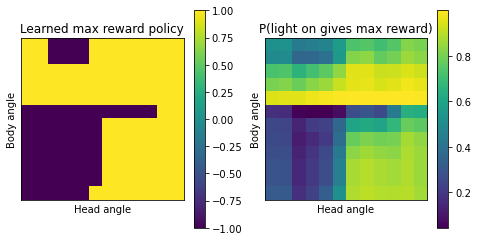

In [238]:
fig,ax = plt.subplots(1,2)
fig.set_size_inches((8,4))
img = ax[0].imshow(np.sign(pred-.5))
plt.colorbar(img,ax=ax[0]);
img = ax[1].imshow(pred)
plt.colorbar(img,ax=ax[1])
[ax[i].set_xticks([]) for i in range(2)]
[ax[i].set_yticks([]) for i in range(2)];
[ax[i].set_xlabel('Head angle') for i in range(2)]
[ax[i].set_ylabel('Body angle') for i in range(2)]
ax[0].set_title('Learned max reward policy')
ax[1].set_title('P(light on gives max reward)');

In [210]:
counts = pt.get_counts(trajdict)

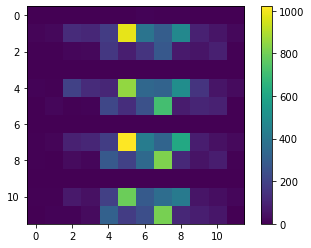

In [211]:
plt.imshow(counts)
plt.colorbar();

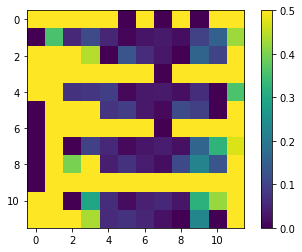

In [212]:
plt.imshow(pol)
plt.colorbar();

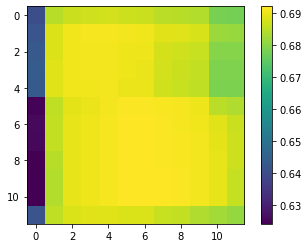

In [213]:
plt.imshow(np.mean(ents,axis=0).reshape(12,12))
plt.colorbar();

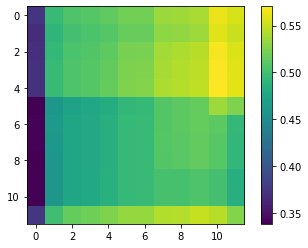

In [214]:
plt.imshow(np.mean(probs,axis=0).reshape(12,12))
plt.colorbar();

In [26]:
df[df['prev_actions'].isin([0,3])]

,t,obs_b,obs_h,prev_actions,next_obs_b,next_obs_h,reward,loc
0,0.391,-120,0,0,-120,-30,-8.803571,"[618.588235296049, 630.8235294172829]"
1,0.547,-120,-30,0,-120,30,-8.343583,"[618.6481481452769, 630.5370370435178]"
2,0.750,-120,30,0,-120,-30,-9.474301,"[618.7142857112345, 630.5892857160402]"
3,0.906,-120,-30,0,-120,-30,-10.473214,"[618.7222222234527, 630.4444444513355]"
4,1.078,-120,-30,0,-120,30,-11.417313,"[619.0701754383019, 629.43859646001]"
...,...,...,...,...,...,...,...,...
3218,294.109,-150,-60,0,-150,-60,-19.964173,"[654.9772727110861, 603.3409090944924]"
3219,294.297,-150,-60,0,-150,-90,-19.295455,"[654.9183673326914, 603.795918397635]"
3220,294.484,-150,-90,0,-150,-30,-18.995748,"[655.2264150797772, 604.8301887025792]"
3221,294.656,-150,-30,0,-150,-30,-18.073657,"[655.3275861931722, 605.6379310483493]"


In [83]:
ents =np.random.randn(4,3)
print(ents)

[[ 1.08506099  0.16195982  0.31531534]
 [-0.53286523 -0.53027011 -0.97923687]
 [ 0.35697352  0.2586811  -0.26824462]
 [ 0.02592116 -3.04879522 -1.2849174 ]]


In [91]:
np.argsort(ents,axis=1)

array([[1, 2, 0],
       [2, 0, 1],
       [2, 1, 0],
       [1, 2, 0]], dtype=int64)

In [112]:
p = np.zeros((3,3))
# The first row is the proportion each state came in first;
# the second row is the proportion it came in second, etc.
# Each column is the proportions for that state.
for i in range(3):
    p[i,:],_ = np.histogram(np.argsort(ents,axis=1)[:,i],bins=range(4),density=True)

In [113]:
p

array([[0.  , 0.5 , 0.5 ],
       [0.25, 0.25, 0.5 ],
       [0.75, 0.25, 0.  ]])

In [143]:
'''
find the maximum prob state. then set sampling prob to that UNLESS it's above 
'''
l = .3
pc = p.copy()
pmax = np.array([.93,.02,.05])
pol = np.zeros(3)
rank = 0
for i in range(len(pol)):
    while np.sum(pc[rank,:])==0:
        rank+=1
    best = np.argmax(pc[rank,:])
    print('best',best)
    pol[best] = pc[rank,best]/np.sum(pc[rank,:])*l
    print('pol',pol)
    if pol[best] > pmax[best]:
        pol[best] = pmax[best]
        print('fixed',pol)
    l -= pol[best]
    print('l',l)
    pc[:,best] = 0
    print(pc)
pol /= (pmax*2)


best 1
pol [0.   0.15 0.  ]
fixed [0.   0.02 0.  ]
l 0.27999999999999997
[[0.   0.   0.5 ]
 [0.25 0.   0.5 ]
 [0.75 0.   0.  ]]
best 2
pol [0.   0.02 0.28]
fixed [0.   0.02 0.05]
l 0.22999999999999998
[[0.   0.   0.  ]
 [0.25 0.   0.  ]
 [0.75 0.   0.  ]]
best 0
pol [0.23 0.02 0.05]
l 0.0
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


In [144]:
pol

array([0.12365591, 0.5       , 0.5       ])

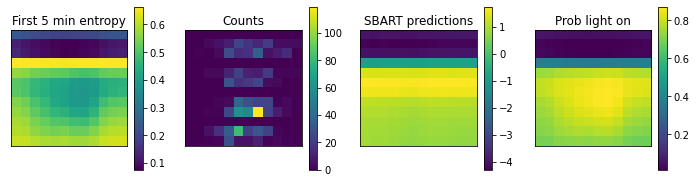

In [31]:
fig,ax = plt.subplots(1,4)
fig.set_size_inches((12,3))
img = ax[0].imshow(ents)
plt.colorbar(img,ax=ax[0])
ax[0].set_title('First 5 min entropy');
img = ax[1].imshow(pt.get_counts(df))
plt.colorbar(img,ax=ax[1])
ax[1].set_title('Counts')
img = ax[2].imshow(sb_mu)
plt.colorbar(img,ax=ax[2])
ax[2].set_title('SBART predictions');

img = ax[3].imshow(probs)
plt.colorbar(img,ax=ax[3])
ax[3].set_title('Prob light on')
[a.set_xticks([]) for a in ax]
[a.set_yticks([]) for a in ax];

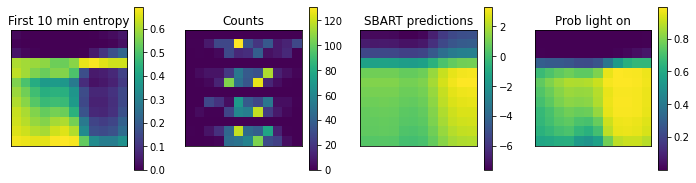

In [33]:
fig,ax = plt.subplots(1,4)
fig.set_size_inches((12,3))
img = ax[0].imshow(ents)
plt.colorbar(img,ax=ax[0])
ax[0].set_title('First 10 min entropy');
img = ax[1].imshow(pt.get_counts(df))
plt.colorbar(img,ax=ax[1])
ax[1].set_title('Counts')
img = ax[2].imshow(sb_mu)
plt.colorbar(img,ax=ax[2])
ax[2].set_title('SBART predictions');

img = ax[3].imshow(probs)
plt.colorbar(img,ax=ax[3])
ax[3].set_title('Prob light on')
[a.set_xticks([]) for a in ax]
[a.set_yticks([]) for a in ax];

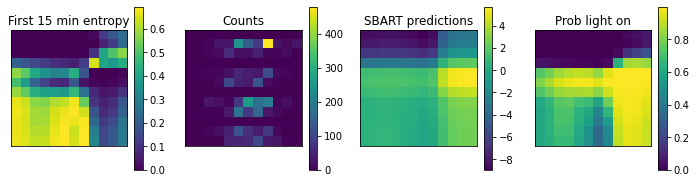

In [35]:
fig,ax = plt.subplots(1,4)
fig.set_size_inches((12,3))
img = ax[0].imshow(ents)
plt.colorbar(img,ax=ax[0])
ax[0].set_title('First 15 min entropy');
img = ax[1].imshow(pt.get_counts(df))
plt.colorbar(img,ax=ax[1])
ax[1].set_title('Counts')
img = ax[2].imshow(sb_mu)
plt.colorbar(img,ax=ax[2])
ax[2].set_title('SBART predictions');

img = ax[3].imshow(probs)
plt.colorbar(img,ax=ax[3])
ax[3].set_title('Prob light on')
[a.set_xticks([]) for a in ax]
[a.set_yticks([]) for a in ax];

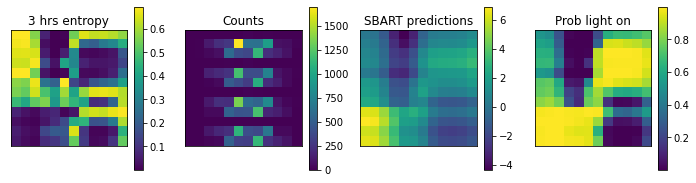

In [18]:
fig,ax = plt.subplots(1,4)
fig.set_size_inches((12,3))
img = ax[0].imshow(ents)
plt.colorbar(img,ax=ax[0])
ax[0].set_title('3 hrs entropy');
img = ax[1].imshow(pt.get_counts(df))
plt.colorbar(img,ax=ax[1])
ax[1].set_title('Counts')
img = ax[2].imshow(sb_mu)
plt.colorbar(img,ax=ax[2])
ax[2].set_title('SBART predictions');

img = ax[3].imshow(probs)
plt.colorbar(img,ax=ax[3])
ax[3].set_title('Prob light on')
[a.set_xticks([]) for a in ax]
[a.set_yticks([]) for a in ax];

## BART hyperparameter search

In [29]:
folder = './Data/03_08_0/'
ind=29
bart = np.load(f'{folder}bart{ind}.npy',allow_pickle=True)

In [30]:
b_d, b_m, b_s = get_bart_stats(bart)
probs, ents = pt.bart2pols(bart)

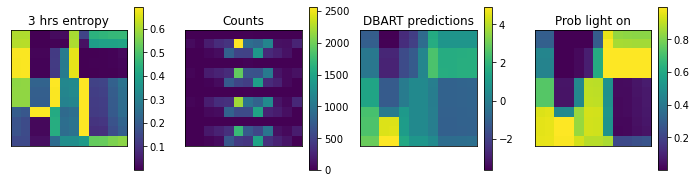

In [27]:
fig,ax = plt.subplots(1,4)
fig.set_size_inches((12,3))
img = ax[0].imshow(ents)
plt.colorbar(img,ax=ax[0])
ax[0].set_title('3 hrs entropy');
img = ax[1].imshow(pt.get_counts(df))
plt.colorbar(img,ax=ax[1])
ax[1].set_title('Counts')
img = ax[2].imshow(b_m)
plt.colorbar(img,ax=ax[2])
ax[2].set_title('DBART predictions');

img = ax[3].imshow(probs)
plt.colorbar(img,ax=ax[3])
ax[3].set_title('Prob light on')
[a.set_xticks([]) for a in ax]
[a.set_yticks([]) for a in ax];

In [14]:
x = np.zeros((2,3))
for a in x:
    print(a)

[0. 0. 0.]
[0. 0. 0.]


In [266]:
def plot_bart_results(bart_type,fname):

    folder = './Data/03_23_0/'
    inds = [15,20,24,29,34,39]

    fig,axs = plt.subplots(len(inds),6)
    fig.set_size_inches((18,23))

    with open(f'{folder}fulltraj.pkl','rb') as f:
        df = pickle.load(f)
    
    for i,ax in enumerate(axs):
        ind = inds[i]
        traj = np.load(f'{folder}traj{ind}.npy')
        ents = np.load(f'{folder}ents{ind}.npy')
        probs = np.load(f'{folder}probs{ind}.npy')
        bart = np.load(f'{folder}{bart_type}{ind}.npy')
        bartsig = np.load(f'{folder}bartsig{ind}.npy')
        with open(f'{folder}traj{ind}.pkl','rb') as f:
            trajdict = pickle.load(f)

        b_d,b_m,b_s = get_bart_stats(bart)
        ents,probs = pt.bart2pols(bart,bartsig)

        img = ax[0].imshow(np.mean(ents,axis=0).reshape(12,12))
        plt.colorbar(img,ax=ax[0])
        ax[0].set_title('Entropy');

        img = ax[1].imshow(pt.get_counts(df))
        plt.colorbar(img,ax=ax[1])
        ax[1].set_title('Counts')

        img = ax[2].imshow(b_m)
        plt.colorbar(img,ax=ax[2])
        ax[2].set_title('Mean Qdel');

        img = ax[3].imshow(b_s)
        plt.colorbar(img,ax=ax[3])
        ax[3].set_title('Std Qdel')

        img = ax[4].imshow(np.mean(probs,axis=0).reshape(12,12))
        plt.colorbar(img,ax=ax[4])
        ax[4].set_title('P(Qdel>0)')

        img = ax[5].imshow(np.round(np.mean(probs,axis=0)).reshape(12,12))
        ax[5].set_title('Best reward policy')

        [a.set_xticks([]) for a in ax]
        [a.set_yticks([]) for a in ax];
        [a.set_xlabel('Head angle') for a in ax]
    
    [axs[i,0].set_ylabel('Body angle') for i in range(len(inds))]
    fig.savefig(fname)

# def plot_one_bart(bart_type,fname):
#     folder = './Data/03_08_0/'
#     inds = [29,29]

#     fig,axs = plt.subplots(len(inds),6)
#     fig.set_size_inches((18,len(inds)*3.5))

    
#     for i,ax in enumerate(axs):
#         ind = inds[i]
#         traj = np.load(f'{folder}traj{ind}.npy')
#         ents = np.load(f'{folder}ents{ind}.npy')
#         probs = np.load(f'{folder}probs{ind}.npy')
#         bart = np.load(f'{folder}{bart_type}{ind}.npy')
#         with open(f'{folder}traj{ind}.pkl','rb') as f:
#             trajdict = pickle.load(f)

#         b_d,b_m,b_s = get_bart_stats(bart)
#         probs,ents = pt.bart2pols(bart)

#         img = ax[0].imshow(ents)
#         plt.colorbar(img,ax=ax[0])
#         ax[0].set_title('Entropy');

#         img = ax[1].imshow(pt.get_counts(df))
#         plt.colorbar(img,ax=ax[1])
#         ax[1].set_title('Counts')

#         img = ax[2].imshow(b_m)
#         plt.colorbar(img,ax=ax[2])
#         ax[2].set_title('Mean Qdel');

#         img = ax[3].imshow(b_s)
#         plt.colorbar(img,ax=ax[3])
#         ax[3].set_title('Std Qdel')

#         img = ax[4].imshow(probs)
#         plt.colorbar(img,ax=ax[4])
#         ax[4].set_title('P(Qdel>0)')

#         img = ax[5].imshow(np.round(probs))
#         ax[5].set_title('Best reward policy')

#         [a.set_xticks([]) for a in ax]
#         [a.set_yticks([]) for a in ax];
#         [a.set_xlabel('Head angle') for a in ax]
    
#     [axs[i,0].set_ylabel('Body angle') for i in range(len(inds))]
#     fig.savefig(fname)

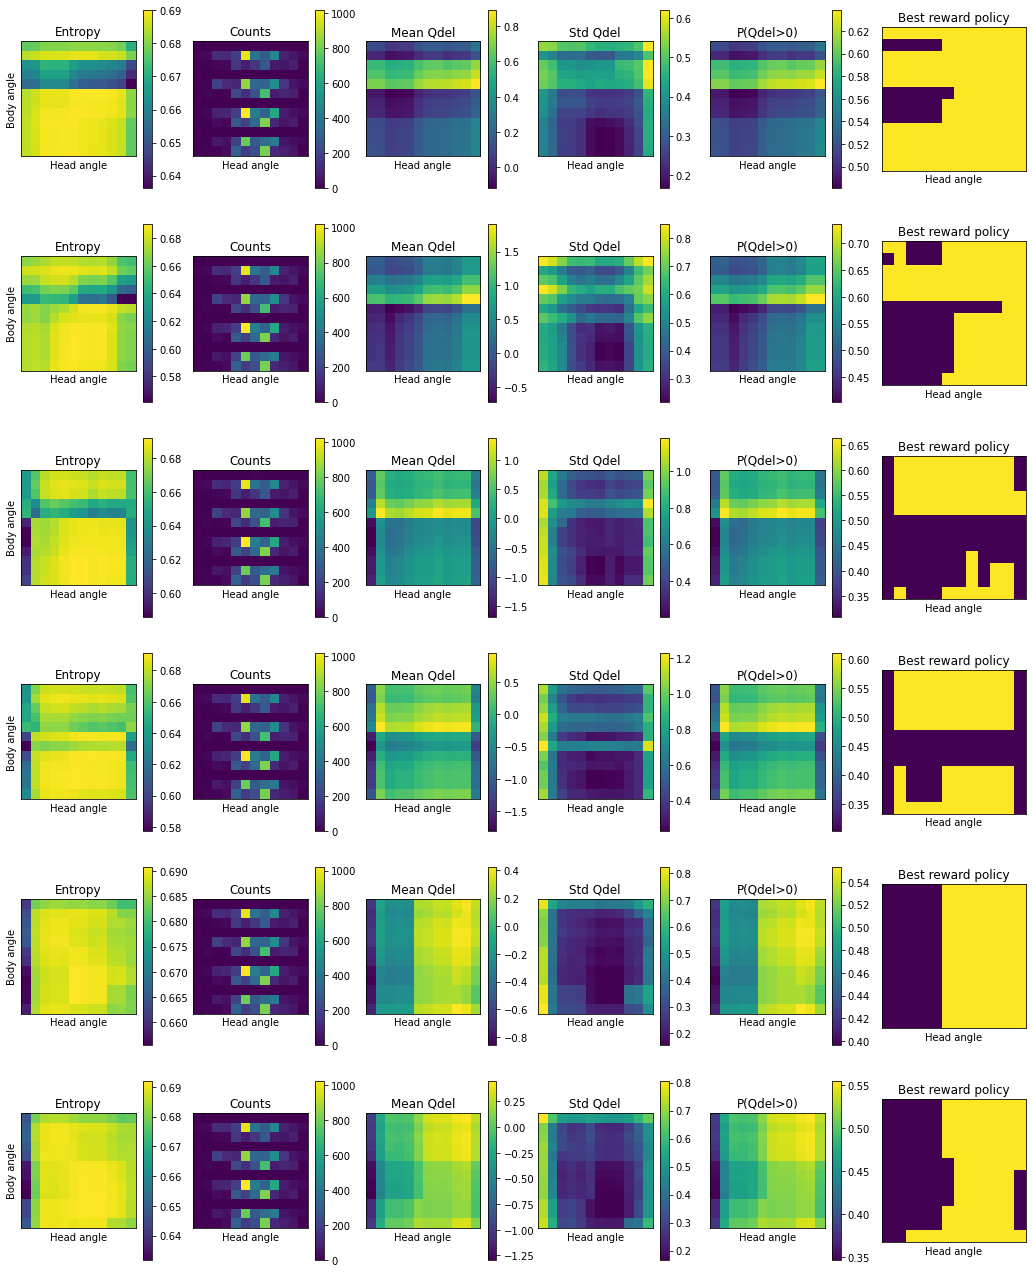

In [267]:
plot_bart_results('bart','bart.jpg')

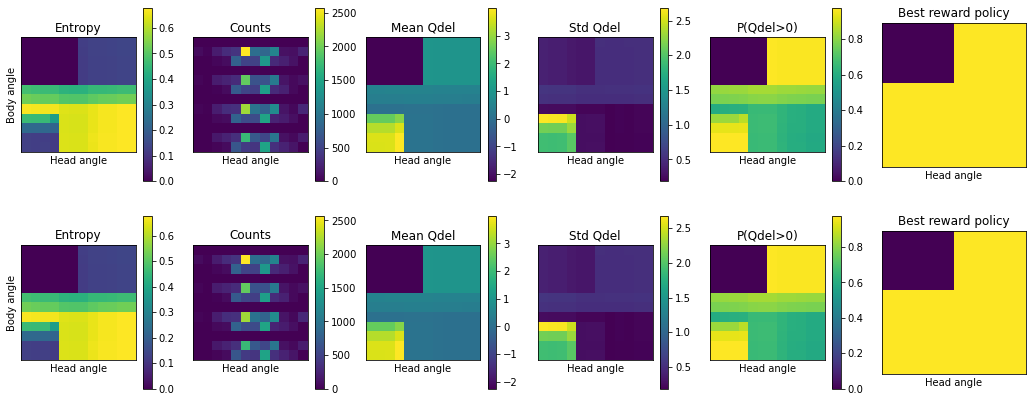

In [25]:
plot_one_bart('dbart_50trees','DBart_50trees.jpg')

#### Big question to answer: are the variances returned from BART aware of data-scarcity? Should I be scaling by sqrt(n)?

Almost definitely yes.
Wait--no, never mind. Need to read this.

What do I want by tomorrow morning?

1. Demonstrations of each BART method
2. Hyperparameters for each method and their meanings.

## For cross-validation, I have a dataset. At each point, I have a mean and variance. That's what BART will output, too. I want to do a grid search over parameters that gives me the closest estimates to the mean and variance. 

HPs to search: 

Sparse?
Theta